In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys 
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [50]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.390822
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in* 



In [51]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.598030 analytic: -1.598030, relative error: 6.232679e-09
numerical: -2.785370 analytic: -2.785370, relative error: 1.805668e-08
numerical: 0.490946 analytic: 0.490946, relative error: 1.673831e-07
numerical: 1.154691 analytic: 1.154691, relative error: 2.343858e-08
numerical: 0.105188 analytic: 0.105188, relative error: 2.053899e-07
numerical: 1.405023 analytic: 1.405023, relative error: 5.439220e-08
numerical: 1.155975 analytic: 1.155975, relative error: 2.112279e-08
numerical: -0.148390 analytic: -0.148390, relative error: 7.906597e-08
numerical: 4.723221 analytic: 4.723221, relative error: 2.660505e-08
numerical: 3.735057 analytic: 3.735057, relative error: 4.836026e-09
numerical: 1.570937 analytic: 1.570937, relative error: 5.274189e-08
numerical: 0.807314 analytic: 0.807314, relative error: 1.096619e-07
numerical: -0.522053 analytic: -0.522053, relative error: 5.319908e-08
numerical: 1.326229 analytic: 1.326229, relative error: 4.916674e-09
numerical: 1.601380 analyt

In [55]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.390822e+00 computed in 0.150811s
vectorized loss: 2.391133e+00 computed in 0.007321s
Loss difference: 0.000312
Gradient difference: 0.000000


In [57]:

# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_sfm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [5e-8, 8e-8, 1e-7, 2e-7, 5e-5]
regularization_strengths = [8e3, 1e4, 2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for rs in regularization_strengths:
        sfm = Softmax()
        sfm.train(X_train, y_train, learning_rate=lr, reg=rs,
                      num_iters=1500, verbose=True)
        
        training_accuracy = np.mean(sfm.predict(X_train) == y_train)
        val_accuracy = np.mean(sfm.predict(X_val) == y_val)
        results[(lr, rs)] = (training_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_sfm = sfm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print(f'best, {best_sfm.lr}, {best_sfm.reg}: %f' % best_val)

iteration 0 / 1500: loss 5.260573
iteration 100 / 1500: loss 4.198879
iteration 200 / 1500: loss 3.839455
iteration 300 / 1500: loss 3.376168
iteration 400 / 1500: loss 3.206776
iteration 500 / 1500: loss 2.986057
iteration 600 / 1500: loss 2.740464
iteration 700 / 1500: loss 2.755756
iteration 800 / 1500: loss 2.725770
iteration 900 / 1500: loss 2.777531
iteration 1000 / 1500: loss 2.546841
iteration 1100 / 1500: loss 2.487338
iteration 1200 / 1500: loss 2.434393
iteration 1300 / 1500: loss 2.307289
iteration 1400 / 1500: loss 2.316857
iteration 0 / 1500: loss 7.029021
iteration 100 / 1500: loss 5.452157
iteration 200 / 1500: loss 4.080556
iteration 300 / 1500: loss 3.834830
iteration 400 / 1500: loss 3.248587
iteration 500 / 1500: loss 2.906152
iteration 600 / 1500: loss 2.767769
iteration 700 / 1500: loss 2.578955
iteration 800 / 1500: loss 2.469635
iteration 900 / 1500: loss 2.405696
iteration 1000 / 1500: loss 2.364369
iteration 1100 / 1500: loss 2.381376
iteration 1200 / 1500: lo

/Users/kevinwong/Python Projects/Data Science/GPT/comp-vision/assignment1/cs231n/classifiers/softmax.py:92: RuntimeWarning: divide by zero encountered in log
  loss -= np.sum(np.log(sum_wx[np.arange(num_train), y]))


lr 5.000000e-08 reg 8.000000e+03 train accuracy: 0.244837 val accuracy: 0.254000
lr 5.000000e-08 reg 1.000000e+04 train accuracy: 0.263592 val accuracy: 0.282000
lr 5.000000e-08 reg 2.500000e+04 train accuracy: 0.313469 val accuracy: 0.329000
lr 5.000000e-08 reg 5.000000e+04 train accuracy: 0.329816 val accuracy: 0.342000
lr 8.000000e-08 reg 8.000000e+03 train accuracy: 0.298694 val accuracy: 0.314000
lr 8.000000e-08 reg 1.000000e+04 train accuracy: 0.302367 val accuracy: 0.329000
lr 8.000000e-08 reg 2.500000e+04 train accuracy: 0.345204 val accuracy: 0.354000
lr 8.000000e-08 reg 5.000000e+04 train accuracy: 0.326510 val accuracy: 0.340000
lr 1.000000e-07 reg 8.000000e+03 train accuracy: 0.321224 val accuracy: 0.339000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.335020 val accuracy: 0.329000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.348633 val accuracy: 0.359000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.329020 val accuracy: 0.346000
lr 2.000000e-07 reg 8.000000

In [59]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_sfm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.377000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



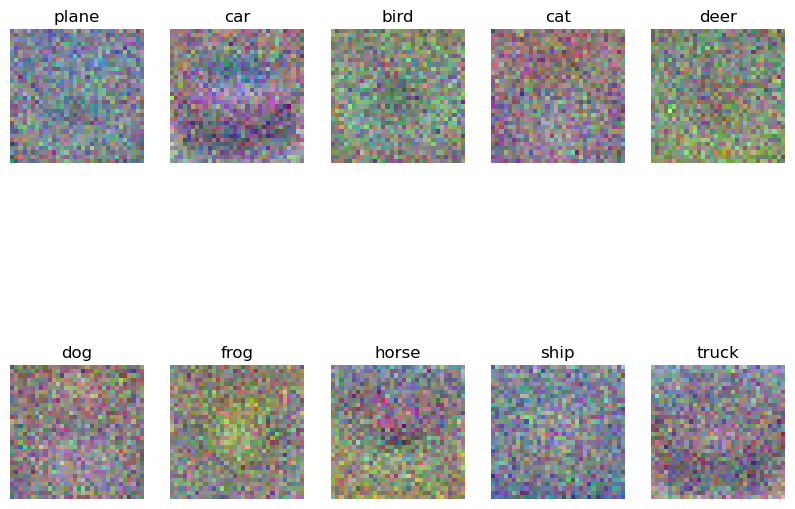

In [60]:
# Visualize the learned weights for each class
w = best_sfm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])